In [45]:
from dolfin import *
#from dolfin import (
    #Mesh, MeshFunction, VectorElement, FunctionSpace, Function,
    #SpatialCoordinate, FacetNormal, Measure, assemble,
    #Identity, grad, det, inv, conditional, ge, ds, parameters
#)
import matplotlib.pyplot as plt
import numpy as np
import os
from ufl import cofac

parameters["form_compiler"]["quadrature_degree"] = 2
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"

In [46]:
meshDir = './HV2'
meshName = os.path.join(meshDir, 'lvgmsh_mesh.xml')
mfName = os.path.join(meshDir, 'lvgmsh_fmaker.xml')


resultDir = os.path.join(meshDir, 'results/')

mesh = Mesh(meshName)
mesh.scale(0.1) # this will scale the mesh unit to be cm
mesh.ufl_cell()

#plot(mesh, edgecolor='k', color="r")

#ax = plt.gca()
#ax.view_init(elev=25, azim=-179)
#plt.show()

fibreName = os.path.join(meshDir, 'HV2_fibre_dir.xml')
sheetName = os.path.join(meshDir, 'HV2_sheet_dir.xml')
normalName = os.path.join(meshDir, 'HV2_normal_dir.xml')

In [47]:
def load_ellipsoid_data(meshName, mfName, fibreName, sheetName, normalName, scale=0.1):
    """Load mesh, boundary markers and fiber fields.
    Returns: mesh, mf, numbering, [fiber, sheet, cross_sheet]
    """

    # Load mesh and mesh function
    mesh = Mesh(meshName)
    if scale is not None:
        mesh.scale(scale)

    cell = mesh.ufl_cell()  # store if needed for element construction
                
    # Load boundary markers (expects an XML MeshFunction file)
    mf = MeshFunction("size_t", mesh, mfName)

    numbering = {
        "BASE": 10,
        "ENDO": 30,
        "EPI": 40
    }

    # Vector function space for fiber directions
    fiber_element = VectorElement("Lagrange", cell, degree=1)
    fiber_space = FunctionSpace(mesh, fiber_element)

    # Load fiber / sheet / normal as Functions (file must exist)
    fiber = Function(fiber_space, fibreName)
    sheet = Function(fiber_space, sheetName)
    cross_sheet = Function(fiber_space, normalName)

    return mesh, mf, numbering, [fiber, sheet, cross_sheet]

def compute_cavity_volume(mesh, mf, numbering, u=None):
    """Compute cavity volume via surface integral.
    - For small displacements (linearized), use V = (1/3) ∫_{S} (X + u) · N dS (approx).
    - If u is None, compute reference volume V0 = (1/3) ∫_S X·N dS.
    Note: sign depends on orientation of N; check with a small test.
    """
    X = SpatialCoordinate(mesh) 
    N = FacetNormal(mesh)

    if u is not None:
        I = Identity(3) # the identity matrix
        F = I + grad(u) # the deformation gradient
        J = det(F)
        vol_form = (-1.0/3.0) * dot(X + u, J * inv(F).T * N)
    else:
        vol_form = (-1.0/3.0) * dot(X, N)
    ds = Measure('ds',domain=mesh,subdomain_data=mf)

    return assemble(vol_form*ds(numbering["ENDO"]))

def subplus(x):
    #return dolfin.conditional(dolfin.ge(x, 1), x, 1.0)
    return conditional(ge(x, 1), x, 1.0)

# Load data (this returns the mesh used later)
mesh, boundary_markers, numbering, fibers = load_ellipsoid_data(
    meshName, mfName, fibreName, sheetName, normalName
)

In [ ]:
# Compute the initial cavity volume of the endocardial surface using the divergence theorem
n_mesh = FacetNormal(mesh)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
X = SpatialCoordinate(mesh)
vol = abs(assemble((-1.0/3.0)*dot(X, n_mesh)*ds(numbering['ENDO'])))

print(vol)

73.7313209876846


In [49]:
# Defines a Taylor–Hood mixed element: quadratic displacement (CG2) + linear pressure (CG1)
# (IDEAL FOR INCOMPRESSIBLE PROBLEMS)
V = VectorElement("CG", mesh.ufl_cell(), 2)
P = FiniteElement("CG", mesh.ufl_cell(), 1)
TH = V*P
W = FunctionSpace(mesh, TH)

# Define functions (trial function w)
w = Function(W)
(u, p) = split(w)
(v, q) = TestFunctions(W)

# Kinematics
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
F = variable(F)
C = F.T*F                   # Right Cauchy-Green tensor
B = F*F.T

# Invariants of deformation tensors
I_1 = tr(C)
J = det(F)

# Material parameters
alpha =1.0
eta = 0.1   # weighting of transversal fiber tension
rho = Constant(1.0)  # kg
a = 0.280*alpha       # kPa
a_f = 1.1685*alpha    # kPa
a_s = 0.116*alpha       # kPa
a_fs = 1.0*alpha       # kPa
b = 7.780       # dimensionless
b_f = 11.83425   # dimensionless
b_s = 8       # dimensionless
b_fs = 4       # dimensionless

In [50]:
# Fiber directions in the reference configuration
f_0 = fibers[0]
s_0 = fibers[1]
n_0 = fibers[2]
f = F*f_0
s = F*s_0
n = F*n_0

# Anisotropic invariants
I_4f = inner(C*f_0,f_0)
I_4s = inner(C*s_0,s_0)
I_4n = inner(C*n_0,n_0)
I8fs = inner(C*f_0, s_0)

# Initial conditions and boundary conditions
boundaries = boundary_markers
zero_displacement = Constant(("0.0", "0.0", "0.0"))

# Homogeneous Dirichlet BC on the base
bcr = DirichletBC(W.sub(0), zero_displacement, boundaries, numbering['BASE'])
bcs = [bcr]
p0 = Constant(0)
T_a = Constant(0)

# Passive part
passive_cauchy_stress = a*exp(b*(I_1 - 3))*B + 2*a_f*(subplus(I_4f)-1)*exp(b_f*pow(subplus(I_4f) - 1, 2))*outer(f,f) \
                        + 2*a_s*(subplus(I_4s)-1)*exp(b_s*pow( subplus(I_4s) - 1, 2))*outer(s,s)  \
                        + a_fs*I8fs*exp( b_fs*pow(I8fs,2) )*( outer(f,s)+outer(s,f) )  \
                        - p*I
P_p = J*passive_cauchy_stress*inv(F).T

# Active part
active_cauchy_stress = T_a*(outer(f,f)+eta*outer(s,s)+eta*outer(n,n))	
P_a = J*active_cauchy_stress*inv(F.T)

P =  P_p + P_a

eq = inner(P,grad(v))*dx + inner(J-1,q)*dx + dot(J*inv(F).T*n_mesh*p0, v)*ds(numbering['ENDO']) 
Jac = derivative(eq, w)

The variables eq and Jac are defining the residual $R(u,p; v,q)=0$, such that
$$\int_\Omega \mathbf{P}:\nabla \mathbf{v} d\Omega + \int_\Omega (J-1)qd\Omega-\int_{\Gamma_{endo}}p_0(\mathbf{J}\mathbf{F}^{-T}\mathbf{n}) \cdot \mathbf{v}d\Gamma=0$$

In [51]:
ffc_options = {"optimize": True,
               "eliminate_zeros": True,
               "precompute_basis_const": True,
               "precompute_ip_const": True}
form_compiler_parameters = {"keep_diagonal": True}

# in this example we will use a newton scheme to solve the nonlinear problem
newton_solver_parameters = {'absolute_tolerance': 1E-3,
                            'relative_tolerance': 1E-3,
                            'maximum_iterations': 50,
                            'report': True,
                            'error_on_nonconvergence': False,
                            'linear_solver': 'mumps',
                            'preconditioner': 'petsc_amg'}

#'linear_solver': 'mumps'

# the linearized problem is solved using a krylov solver
krylov_solver_parameters = {'absolute_tolerance': 1E-3,
                            'relative_tolerance': 1E-3,
                            'nonzero_initial_guess': True,
                            'error_on_nonconvergence': True,
                            'monitor_convergence': True,
                            'report': True,
                            'divergence_limit': 1E+12}

solver_parameters = {'newton_solver': newton_solver_parameters,
                     'krylov_solver': krylov_solver_parameters,
                     'condition_number': False}



solver = NonlinearVariationalSolver(None)
prm = solver.parameters
# newton solver settings
prm['newton_solver']['convergence_criterion'] = 'incremental'
prm['newton_solver']['absolute_tolerance'] = solver_parameters['newton_solver']['absolute_tolerance']
prm['newton_solver']['relative_tolerance'] = solver_parameters['newton_solver']['relative_tolerance']
prm['newton_solver']['maximum_iterations'] = solver_parameters['newton_solver']['maximum_iterations']
prm['newton_solver']['report'] = solver_parameters['newton_solver']['report']
prm['newton_solver']['error_on_nonconvergence'] = solver_parameters['newton_solver']['error_on_nonconvergence']
prm['newton_solver']['linear_solver'] = solver_parameters['newton_solver']['linear_solver']
#if prm['newton_solver']['linear_solver'] == 'gmres':
#    prm['newton_solver']['preconditioner'] = 'icc'
prm['newton_solver']['krylov_solver']['absolute_tolerance'] = solver_parameters['krylov_solver'][
            'absolute_tolerance']
prm['newton_solver']['krylov_solver']['maximum_iterations'] = 10000
prm['newton_solver']['krylov_solver']['relative_tolerance'] = solver_parameters['krylov_solver'][
            'relative_tolerance']
prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = solver_parameters['krylov_solver'][
            'nonzero_initial_guess']
prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = solver_parameters['krylov_solver'][
            'error_on_nonconvergence']
prm['newton_solver']['krylov_solver']['monitor_convergence'] = solver_parameters['krylov_solver'][
            'monitor_convergence']
prm['newton_solver']['krylov_solver']['report'] = solver_parameters['krylov_solver']['report']
prm['newton_solver']['krylov_solver']['divergence_limit'] = solver_parameters['krylov_solver'][
            'divergence_limit']

In [52]:
total_pressure = 10*133.3/1000.0 #in kPa
steps = 20
volume =  np.zeros(steps+1)
pressure= np.zeros(steps+1)
volume[0] = compute_cavity_volume(mesh,boundary_markers,numbering,u)
pressure[0] = 0.0
#saveFile= File(f"{resultDir}/result.pvd")

# --- Output files ---
save_u = File(f"{resultDir}/u.pvd")
save_e = File(f"{resultDir}/strain.pvd")
save_S = File(f"{resultDir}/stress.pvd")

# --- Function spaces for derived quantities ---
V = VectorFunctionSpace(mesh, 'P', 1)
T = TensorFunctionSpace(mesh, 'P', 1)
eps = Function(T, name="strain")
PK2 = Function(T, name="PK2_stress")
   
for i in range(steps):
    print('%i/%i, pressure = %f' % (i+1, steps, total_pressure/steps*(i+1)))
    current_pressure = total_pressure/steps*(i+1) 
    p0.assign(current_pressure)
    T_a.assign(0)
    #solve(eq==0,w,bcs,J=Jac)
    problem = NonlinearVariationalProblem(eq, w, bcs, J=Jac)
    solver = NonlinearVariationalSolver(problem)
    
    prm = solver.parameters
    # newton solver settings
    prm['newton_solver']['convergence_criterion'] = 'incremental'
    prm['newton_solver']['absolute_tolerance'] = solver_parameters['newton_solver']['absolute_tolerance']
    prm['newton_solver']['relative_tolerance'] = solver_parameters['newton_solver']['relative_tolerance']
    prm['newton_solver']['maximum_iterations'] = solver_parameters['newton_solver']['maximum_iterations']
    prm['newton_solver']['report'] = solver_parameters['newton_solver']['report']
    prm['newton_solver']['error_on_nonconvergence'] = solver_parameters['newton_solver']['error_on_nonconvergence']
    prm['newton_solver']['linear_solver'] = solver_parameters['newton_solver']['linear_solver']
    #if prm['newton_solver']['linear_solver'] == 'gmres':
    #    prm['newton_solver']['preconditioner'] = 'icc'
    prm['newton_solver']['krylov_solver']['absolute_tolerance'] = solver_parameters['krylov_solver'][
                'absolute_tolerance']
    prm['newton_solver']['krylov_solver']['maximum_iterations'] = 10000
    prm['newton_solver']['krylov_solver']['relative_tolerance'] = solver_parameters['krylov_solver'][
                'relative_tolerance']
    prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = solver_parameters['krylov_solver'][
                'nonzero_initial_guess']
    prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = solver_parameters['krylov_solver'][
                'error_on_nonconvergence']
    prm['newton_solver']['krylov_solver']['monitor_convergence'] = solver_parameters['krylov_solver'][
                'monitor_convergence']
    prm['newton_solver']['krylov_solver']['report'] = solver_parameters['krylov_solver']['report']
    prm['newton_solver']['krylov_solver']['divergence_limit'] = solver_parameters['krylov_solver'][
                'divergence_limit']

    
    solver.solve()
    
    # --- Extract displacement ---
    u = w.split()[0]

    # --- Compute strain (Green–Lagrange) ---
    F = Identity(3) + grad(u)
    C = F.T * F
    E = 0.5 * (C - Identity(3))
    eps.assign(project(E, T))

    # --- Compute 2nd Piola–Kirchhoff stress (placeholder Neo-Hookean) ---
    mu = Constant(10.0)     # shear modulus
    lmbda = Constant(10.0)  # Lamé parameter
    S = lmbda * tr(E) * Identity(3) + 2 * mu * E
    PK2.assign(project(S, T))

    # --- Compute volume ---
    volume[i+1] = compute_cavity_volume(mesh,boundary_markers,numbering,u)
    pressure[i+1] = current_pressure

    # --- Save all fields ---
    u.rename('displacement', '')
    eps.rename('strain', '')
    PK2.rename('stress', '')

    save_u << (u, float(i) + 1)
    save_e << (eps, float(i) + 1)
    save_S << (PK2, float(i) + 1)
    
    #u.rename('displacement', 'u')
    #saveFile << (u, float(i) + 1)

print("\n✅ Simulation complete. Results saved in:")
print(f"  {resultDir}/u.pvd")
print(f"  {resultDir}/strain.pvd")
print(f"  {resultDir}/stress.pvd")

1/20, pressure = 0.066650
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 5.373e+01 (tol = 1.000e-03) r (rel) = 1.000e+00 (tol = 1.000e-03)
        Newton iteration 1: r (abs) = 2.089e+01 (tol = 1.000e-03) r (rel) = 3.889e-01 (tol = 1.000e-03)
        Newton iteration 2: r (abs) = 1.323e+01 (tol = 1.000e-03) r (rel) = 2.462e-01 (tol = 1.000e-03)
        Newton iteration 3: r (abs) = 8.579e+00 (tol = 1.000e-03) r (rel) = 1.597e-01 (tol = 1.000e-03)
        Newton iteration 4: r (abs) = 5.299e+00 (tol = 1.000e-03) r (rel) = 9.864e-02 (tol = 1.000e-03)
        Newton iteration 5: r (abs) = 3.435e+00 (tol = 1.000e-03) r (rel) = 6.394e-02 (tol = 1.000e-03)
        Newton iteration 6: r (abs) = 1.961e+00 (tol = 1.000e-03) r (rel) = 3.650e-02 (tol = 1.000e-03)
        Newton iteration 7: r (abs) = 9.703e-01 (tol = 1.000e-03) r (rel) = 1.806e-02 (tol = 1.000e-03)
        Newton iteration 8: r (abs) = 4.003e-01 (tol = 1.000e-03) r (rel) = 7.451e-03 (tol = 1.00

[0.      0.06665 0.1333  0.19995 0.2666  0.33325 0.3999  0.46655 0.5332
 0.59985 0.6665  0.73315 0.7998  0.86645 0.9331  0.99975 1.0664  1.13305
 1.1997  1.26635 1.333  ]
[ 73.73132099  92.22829594 102.16452577 108.51015232 113.07286145
 116.60489855 119.47246353 121.87932723 123.94888123 125.76144888
 127.37195595 128.81961257 130.13331944 131.33512059 132.44202784
 133.46755696 134.42249505 135.31568034 136.15441723 136.94480104
 137.69194915]


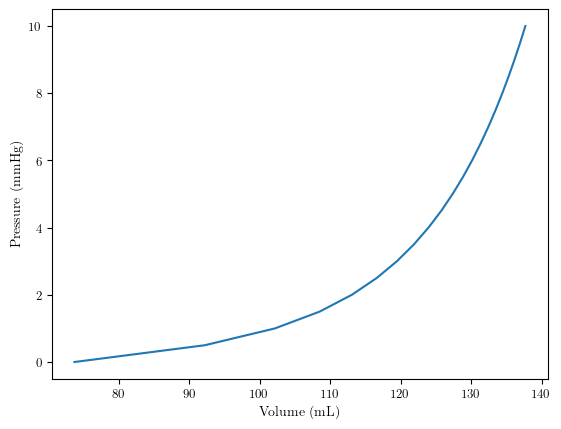

In [54]:
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

print(pressure)
print(volume)
plt.plot(volume, pressure*1000.0/133.3)
plt.xlabel('Volume (mL)')
plt.ylabel('Pressure (mmHg)')
plt.savefig("pv_curve.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [55]:
# https://fenicsproject.discourse.group/t/how-to-choose-projection-space-for-stress-tensor-post-processing/5568

# Post-processing: project the stress tensor
# Define a discontinuous tensor space (DG0) for projecting the Cauchy stress.
Vsig = TensorFunctionSpace(mesh, "DG", degree=0) # elementwise constant tensors (one value per element)
sig_num = Function(Vsig, name="Stress Numeric")


u = w.split()[0]
p = w.split()[1]

# Rebuilds deformation measures using the converged displacement field
F = I + grad(u)             # Deformation gradient
F = variable(F)
C = F.T*F                   # Right Cauchy-Green tensor
B = F*F.T

I_1 = tr(C)
J = det(F)

f = F*f_0
s = F*s_0
n = F*n_0

# Invariants
I_4f = inner(C*f_0,f_0)
I_4s = inner(C*s_0,s_0)
I_4n = inner(C*n_0,n_0)
I8fs = inner(C*f_0, s_0)

# Recompute the total Cauchy stress field at equilibrium and projects it onto the DG space
cauchy_stress = a*exp(b*(I_1 - 3))*B + 2*a_f*(subplus(I_4f)-1)*exp(b_f*pow( subplus(I_4f) - 1, 2))*outer(f,f) \
                        + 2*a_s*(subplus(I_4s)-1)*exp(b_s*pow( subplus(I_4s) - 1, 2))*outer(s,s)  \
                        + a_fs*I8fs*exp( b_fs*pow(I8fs,2) )*( outer(f,s)+outer(s,f) )  \
                        - p*I

sig_num.assign(project(cauchy_stress, Vsig))

In [56]:
# Check equilibrium residual
import dolfin

P_p = J*passive_cauchy_stress*inv(F).T
eq = inner(P_p,grad(v))*dx + inner(J-1,q)*dx + dot(J*inv(F).T*n_mesh*p0, v)*ds(numbering['ENDO']) 

Div_P = dolfin.div(P_p)
Psi_V = inner(Div_P, Div_P)
N = FacetNormal(mesh)
Jump_P_N = dolfin.jump(P, N)
cell_h = dolfin.Constant(mesh.hmin())
Psi_F = dolfin.inner(Jump_P_N, Jump_P_N)/cell_h
dF = dolfin.Measure('dS', mesh)
Psi_F_energy = assemble(Psi_F*dF)
DivP_energy = assemble(Psi_V*dx)

print(DivP_energy+Psi_F_energy)


9573.261122129737


In [57]:
# Check energy balance 
eq = inner(P_p,grad(u))*dx + inner(J-1,p)*dx + dot(J*inv(F).T*n_mesh*p0, u)*ds(numbering['ENDO']) 
eq_internal = inner(P_p,grad(u))*dx + inner(J-1,p)*dx 
eq_external = dot(J*inv(F).T*n_mesh*p0, u)*ds(numbering['ENDO'])
total_eq = assemble(eq)
total_eq_internal = assemble(eq_internal)
total_eq_external = assemble(eq_external)
print(total_eq, total_eq_internal, total_eq_external)

2.1621915369252065e-10 104.07190830027899 -104.07190830006276


As can be seen, $\lim_{\to\infty} eq = 0$ and $\mid$ internal work $\mid$ = $\mid$ external work $\mid$, meaning the system achieved equilibrium and boundary conditions were correctly enforced.

In [58]:
# trying to say what is the value of stress projection on the endo surface 
# https://fenicsproject.discourse.group/t/why-is-the-normal-stress-non-zero-at-boundary-where-i-impose-zero-normal-stress/5193
V = VectorFunctionSpace(mesh, "CG", 1)
u_int = project(u, V)
deformed_mesh = Mesh(mesh)
ALE.move(deformed_mesh, u_int)
n_mesh_def = FacetNormal(deformed_mesh)

# This verifies that the weak enforcement of pressure (through the surface integral) results in correct average normal stress.
endo_area = assemble(1*ds(numbering['ENDO']))
print(endo_area)

P_p = J*cauchy_stress*inv(F).T

stress_nor = dot(P_p*n_mesh, n_mesh)*ds(numbering['ENDO']) #now need to figure out the right value of first PK
total_stress_nor = assemble(stress_nor)

p_nor = dot( -J*p0*inv(F).T*n_mesh, n_mesh)*ds(numbering['ENDO'])
#p_nor = J*p0*ds(numbering['ENDO'])
total_p_nor = assemble(p_nor)

print(total_stress_nor/endo_area)
print(total_p_nor/endo_area)

82.59033627721838
-0.30287458427520764
-1.9441558599159168


In [59]:
dFE = FiniteElement("DG", deformed_mesh.ufl_cell(), 0)
FE = FiniteElement("Lagrange",  mesh.ufl_cell() ,1)
vFE = VectorElement(FE)
tFE = TensorElement(dFE)
fileResults = XDMFFile(resultDir+"output.xdmf")
fileResults.parameters["flush_output"] = True
fileResults.parameters["functions_share_mesh"] = True

U = FunctionSpace(mesh, dFE)
V = FunctionSpace(mesh, vFE)
W = FunctionSpace(mesh, tFE)

stress = Function(W, name='Stress')
stress.assign(project(cauchy_stress, W))
fileResults.write(stress,0.)

In [60]:
## Fenics does not work with new version of Matplotlib for showing the mesh in jupyter
## ParaView or other visualization software should be used instead

# Plot the deformed cube and the original
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (20,10))
# Plot the result on to of the original
#axes1 = fig.add_subplot(projection = '3d')

V = VectorFunctionSpace(mesh, "CG", 1)
u_int = project(u, V)
deformed_mesh = Mesh(mesh)
ALE.move(deformed_mesh, u_int)


#plot(deformed_mesh, alpha=0.1, edgecolor='k', color='w')
#plot(mesh, color="r")

#ax = plt.gca()
#ax.view_init(elev=25, azim=-179)
#ax.set_axis_on()
plt.show()


#mesh_file = dolfin.File(f"{save_dir}/lv_deformed.pvd")
#mesh_file << deformed_mesh

<Figure size 2000x1000 with 0 Axes>